We will reproduce the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


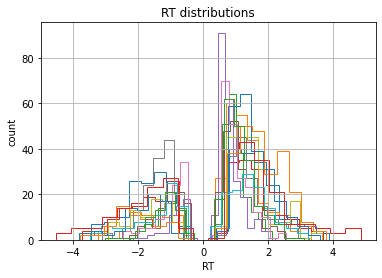

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 105.4 sec

In [9]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97193,0.0922786,1.79377,1.91445,1.96894,2.03143,2.15466,0.00244947
a_std,0.339437,0.0798672,0.219797,0.282409,0.326078,0.381108,0.532223,0.00257075
a_subj.0,2.19505,0.0655314,2.07268,2.15097,2.19389,2.23929,2.32556,0.00191006
a_subj.1,2.11544,0.0665342,1.9816,2.07139,2.11436,2.15777,2.25097,0.00212839


Plotting a
Plotting a_std
Plotting v
Plotting t


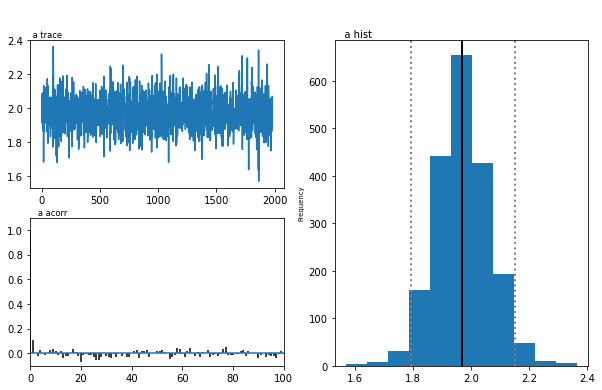

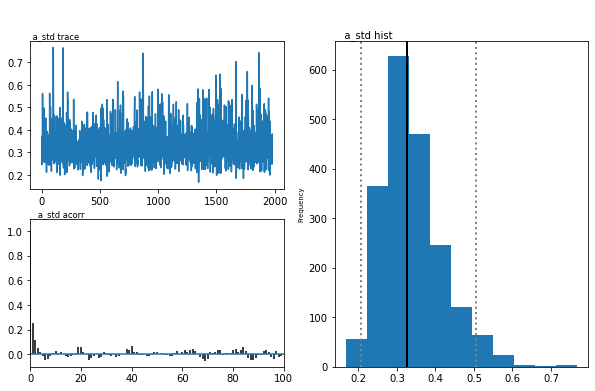

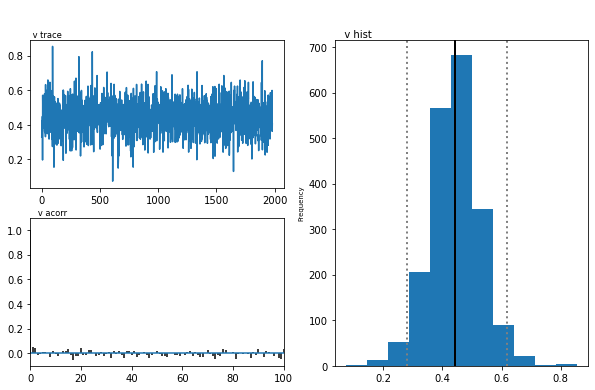

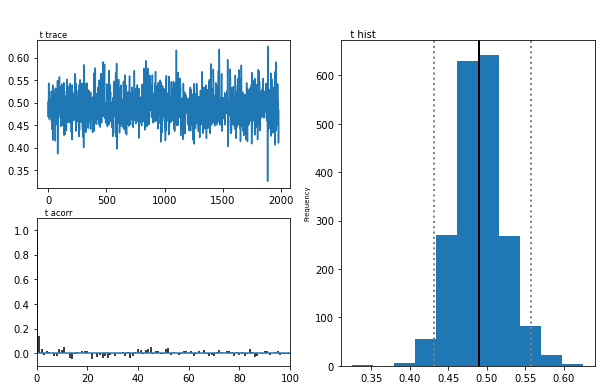

In [10]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

Calculate Gelman_rubin r hat.
The original tutorial used for loop:

In [11]:
# models = []
# for i in range(5):
#     m = hddm.HDDM(data)
#     m.find_starting_values()
#     m.sample(5000, burn=20)
#     models.append(m)

# hddm.analyze.gelman_rubin(models)

you can also replace the for-loop with parallel processing:

In [12]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm1'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m2 = hddm.HDDM(data)
    m2.find_starting_values()
    m2.sample(5000, burn=20,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m2.save(mname)
    
    return m2

In [13]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [14]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

models_2 = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
285.528s elapsed

running model0
 [-----------------95%----------------  ] 4788 of 5000 complete in 283.8 sec
running model1
 [-----------------95%----------------  ] 4781 of 5000 complete in 284.4 sec
running model2
 [-----------------96%----------------  ] 4824 of 5000 complete in 283.4 sec
running model3
 [-----------------96%----------------  ] 4802 of 5000 complete in 283.3 sec



Running 4 chains used: 300.546045 seconds.


In [15]:
hddm.analyze.gelman_rubin(models_2)

{'a': 1.0001096021044062,
 'a_std': 0.9999367960833465,
 'a_subj.0': 1.0001364467879843,
 'a_subj.1': 1.0000284277673082,
 'a_subj.2': 1.00008905956555,
 'a_subj.3': 1.0001569949058968,
 'a_subj.4': 1.000119507907369,
 'a_subj.5': 0.9999283080453217,
 'a_subj.6': 1.0000278548194703,
 'a_subj.7': 1.0004579909198728,
 'a_subj.8': 1.000283512341078,
 'a_subj.9': 1.000220067471393,
 'a_subj.10': 0.9999142766911228,
 'a_subj.11': 1.000367023103966,
 'a_subj.12': 0.9999427535627861,
 'a_subj.13': 1.0001356676609552,
 'v': 0.9999553783820363,
 'v_std': 1.0001822903665474,
 'v_subj.0': 0.9999754565353322,
 'v_subj.1': 1.0000835446271945,
 'v_subj.2': 1.0000058142365666,
 'v_subj.3': 1.0004711111789637,
 'v_subj.4': 1.0001572429426366,
 'v_subj.5': 0.9999622181257145,
 'v_subj.6': 1.0001926122691809,
 'v_subj.7': 1.0000396857417826,
 'v_subj.8': 1.000058192324099,
 'v_subj.9': 0.9999683666482494,
 'v_subj.10': 1.0000885785743803,
 'v_subj.11': 1.0001880005035384,
 'v_subj.12': 1.000073237576739

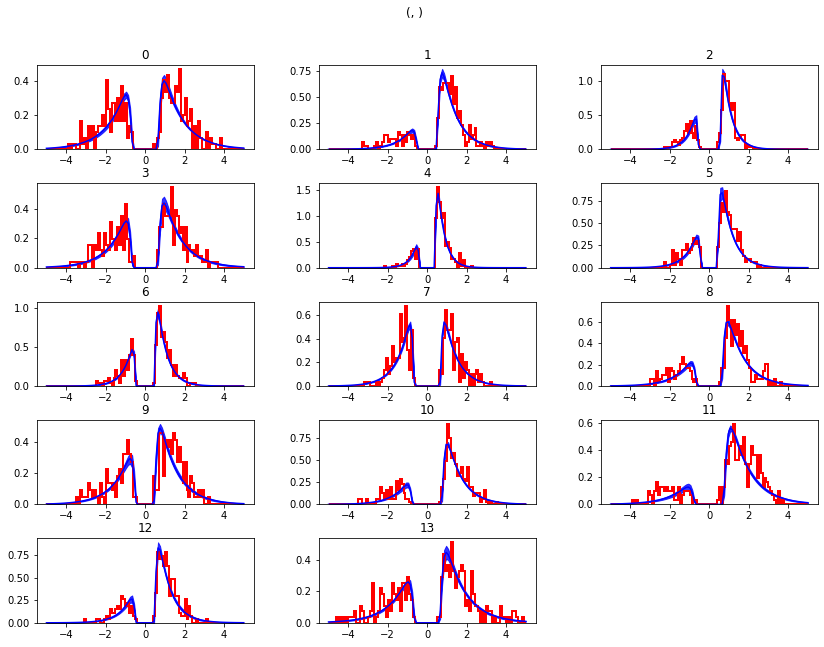

In [16]:
models_2[0].plot_posterior_predictive(figsize=(14, 10))

In [17]:
m_comb = kabuki.utils.concat_models(models_2) # combine four chains together

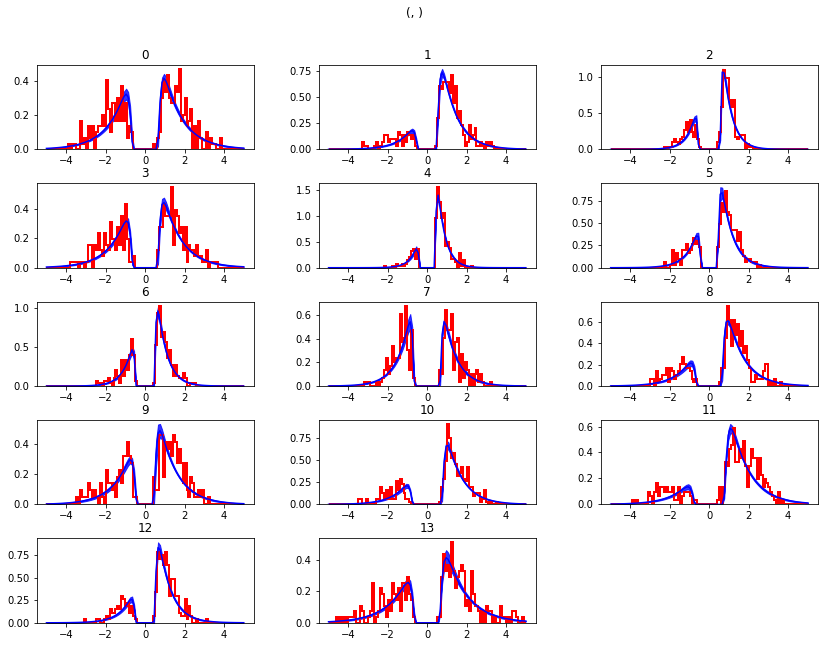

In [18]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [19]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [ ]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
450.701s elapsed

running model (depends on stim) 0
 [-----------------62%---               ] 3128 of 5000 complete in 446.9 sec
running model (depends on stim) 1
 [-----------------62%---               ] 3143 of 5000 complete in 447.5 sec
running model (depends on stim) 2
 [-----------------63%----              ] 3163 of 5000 complete in 447.5 sec
running model (depends on stim) 3
 [-----------------62%---               ] 3146 of 5000 complete in 447.1 sec


In [ ]:
m_stim_all = kabuki.utils.concat_models(m_stim_list) 

In [ ]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [ ]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

In [ ]:
print("Lumped model DIC: %f" % m.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

## Within-subject effects

In [ ]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [ ]:
# define a function to run model in parallel
def run_m_reg(id):
    print('running within-subj model %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm_reg'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(5000, burn=1000,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [ ]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m_reg, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_reg_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

In [ ]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

In [ ]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                              "v_C(stim, Treatment('WL'))[T.LL]",
                                              "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [ ]:
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=200)

In [ ]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [ ]:
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=200)

In [ ]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing witih outliers

In [ ]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

In [ ]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

In [ ]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [ ]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

In [ ]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')